# Irrigated crop water requirements

* **Products used:** 
[WaPOR](https://docs.digitalearthafrica.org/en/latest/data_specs/WaPOR_specs.html), 
[crop_mask](https://explorer.digitalearth.africa/crop_mask)

## Background
The water requirement for irrigated crops can be estimated using a range of spatial data related to actual and potential evapotranspiration. The estimation can assist in optimising the volume and timing of irrigation events and ensure that water resources are appropriately managed. This can enhance overall water use efficiency and support data-driven, effective use of water resources.

## Description
This notebook shows how actual and reference evapotranspiration can be used to identify how adequate previous irrigation has been for a given area and calculate the water deficit, if any.

1. First, cropland area is identified using the cropland extent map.
2. Second, actual water usage for 2024 is estimated.
3. Finally, the water deficit is plotted and calculated to inform irrigation requirements for future seasons.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Tools` package.

In [31]:
%matplotlib inline

import datacube
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd

from datacube.utils.masking import mask_invalid_data
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import display_map
from deafrica_tools.load_wapor import get_all_WaPORv3_mapsets, get_WaPORv3_info, load_wapor_ds
from odc.geo.geom import Geometry
from odc.geo.xr import xr_reproject
from wapordl import wapor_map, wapor_ts

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Irrigation_water')

### Analysis parameters

The cell below specifies the folder where the downloaded data will be stored. If you are using this script repeatedly, it is recommended you empty this folder from time to time to reduce storage on the Sandbox volume. 

In [3]:
folder = "../Supplementary_data/WaPOR" # folder that the data will be sent to


Next, the area of interest is defined. This can also be a `.geojson` file which the loading function accepts. Otherwise, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 30.75`, `lon = 31.35`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (30.75, 31.35).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 30.75`, `lon = 31.35`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(30.75, 31.35)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as an ` Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

As for the [loading WaPOR data notebook](../Datasets/WaPOR.ipynb), this demonstration notebook loads an area of cropland in the Nile Delta, Egypt. The Nile Delta supports irrigated agriculture in a very arid climate. This means it has very low cloud cover and easily distinguishable cropping patterns from satellite imagery, making it a useful testing area for Earth Observation based analyses.

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=30.75, lon=31.35, buffer=0.03)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

region = [geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[2], geopolygon_gdf.total_bounds[3]]

display_map(x=lon_range, y=lat_range)

## Load the cropland mask

We are interested in irrigation, so we limit our analysis to cropland only. We are **making the assumption that all cropland in the area of interest is irrigated**, which is reasonably safe in Egypt given its very dry climate and reliance on irrigation. In other regions, other irrigated area or land use/land cover classification layers may be required to isolate the analysis to irrigated agriculture.

Firstly, we load the cropland mask for the area of interest.

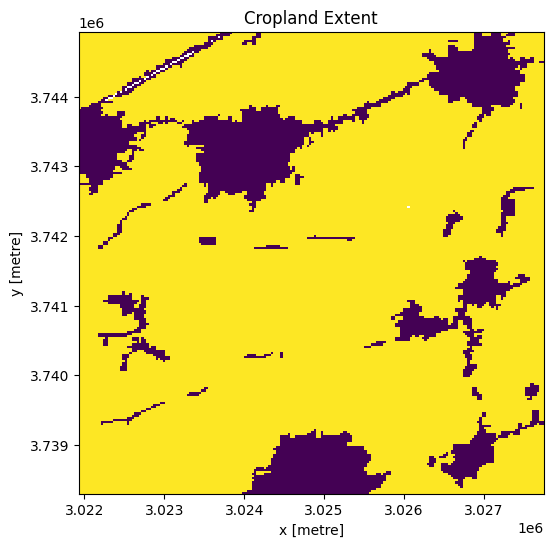

In [5]:
cm = dc.load(
    product="crop_mask",
    y = (region[1],region[3]),
    x = (region[0],region[2]),
    time=("2019"),
    resolution = (-30,30),
    measurements="filtered",
    resampling="nearest"
).filtered.squeeze()

cm.where(cm < 255).plot.imshow(
    add_colorbar=False, figsize=(6, 6)
)  # we filter to <255 to omit missing data
plt.title("Cropland Extent");

## Load reference ET

Reference evapotranspiration (ET) is the amount of water vapour that would be lost to the atmosphere from well-watered grass. It represents the ET that would apply to short crops in ideal growing conditions under given climate conditions. It is low resolution because it depends on climate information, such as temperature and wind speed, which are generally available at low resolution.

In [6]:
variable = "L1-RET-M"
period= ["2024-01-01", "2024-12-31"]
region_big = [geopolygon_gdf.total_bounds[0] - 2, geopolygon_gdf.total_bounds[1] - 2,
              geopolygon_gdf.total_bounds[2] + 2, geopolygon_gdf.total_bounds[3] + 2]

ret = wapor_map(region_big, variable, period, folder, extension = '.nc')

INFO: Found 12 files for L1-RET-M.
INFO: Converting from `.tif` to `.nc`.


In [7]:
ret_xr = load_wapor_ds(filename=ret, variable=variable)

In [8]:
ret_xr = ret_xr.where(ret_xr['L1-RET-M'] > 0)

ret_xr

<xarray.Dataset> Size: 25kB
Dimensions:      (time: 12, y: 18, x: 14)
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * y            (y) float64 144B 32.88 32.62 32.38 32.12 ... 29.12 28.88 28.62
  * x            (x) float64 112B 29.22 29.53 29.84 30.16 ... 32.66 32.97 33.28
    spatial_ref  int32 4B 4326
Data variables:
    L1-RET-M     (time, y, x) float64 24kB nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    lat#long_name:        latitude
    lat#standard_name:    latitude
    lat#units:            degrees_north
    lon#long_name:        longitude
    lon#standard_name:    longitude
    lon#units:            degrees_east
    ...                   ...
    overview:             NONE
    temporal_resolution:  Month
    units:                mm/month
    scale_factor:         0.1
    _FillValue:           -9999
    add_offset:           0.0

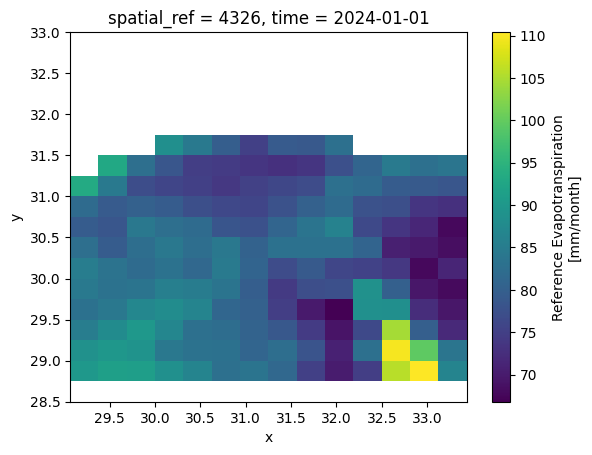

In [9]:
ret_xr.isel(time=0)['L1-RET-M'].plot()

In [10]:
ret_ts = ret_xr.mean(["x", "y"])

ret_ts

<xarray.Dataset> Size: 196B
Dimensions:      (time: 12)
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
    spatial_ref  int32 4B 4326
Data variables:
    L1-RET-M     (time) float64 96B 80.8 90.87 139.6 185.1 ... 149.0 92.03 76.74
Attributes: (12/13)
    lat#long_name:        latitude
    lat#standard_name:    latitude
    lat#units:            degrees_north
    lon#long_name:        longitude
    lon#standard_name:    longitude
    lon#units:            degrees_east
    ...                   ...
    overview:             NONE
    temporal_resolution:  Month
    units:                mm/month
    scale_factor:         0.1
    _FillValue:           -9999
    add_offset:           0.0

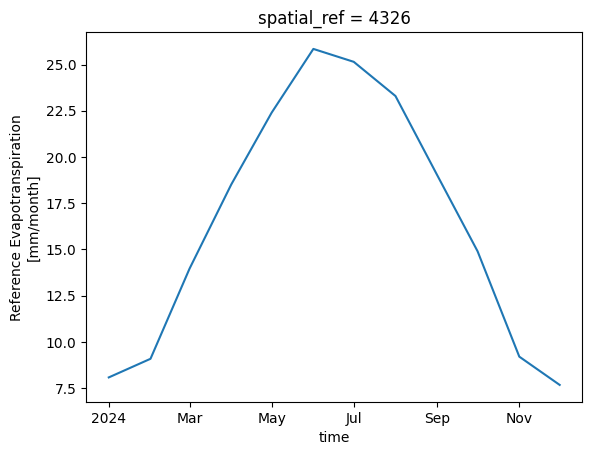

In [11]:
(ret_ts['L1-RET-M']*0.1).plot()

## Load actual evapotranspiration

In [16]:
variable = "L3-AETI-M"
period= ["2024-01-01", "2024-12-31"]

eta = wapor_map(region, variable, period, folder, extension = '.nc')

INFO: Found 12 files for L3-AETI-M.
INFO: Converting from `.tif` to `.nc`.


In [22]:
eta_xr = load_wapor_ds(filename=eta, variable=variable)

eta_xr = eta_xr.where(eta_xr['L3-AETI-M'] > 0 & cm.)

eta_xr

<xarray.Dataset> Size: 10MB
Dimensions:      (time: 12, y: 338, x: 294)
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * y            (y) float64 3kB 3.406e+06 3.406e+06 ... 3.4e+06 3.4e+06
  * x            (x) float64 2kB 3.391e+05 3.392e+05 ... 3.45e+05 3.45e+05
    spatial_ref  int32 4B 32636
Data variables:
    L3-AETI-M    (time, y, x) float64 10MB nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:            Actual EvapoTranspiration and Interception
    overview:             NONE
    temporal_resolution:  Month
    units:                mm/month
    scale_factor:         0.1
    _FillValue:           -9999
    add_offset:           0.0

In [28]:
cm

<xarray.DataArray 'filtered' (y: 221, x: 194)> Size: 43kB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], shape=(221, 194), dtype=uint8)
Coordinates:
  * y            (y) float64 2kB 3.745e+06 3.745e+06 ... 3.738e+06 3.738e+06
  * x            (x) float64 2kB 3.022e+06 3.022e+06 ... 3.028e+06 3.028e+06
    time         datetime64[ns] 8B 2019-07-02T11:59:59.999999
    spatial_ref  int32 4B 6933
Attributes:
    units:         1
    nodata:        255
    crs:           epsg:6933
    grid_mapping:  spatial_ref

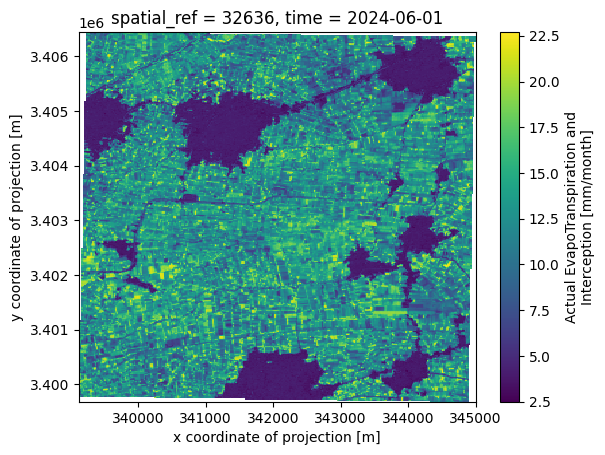

In [26]:
(eta_xr.isel(time=5)['L3-AETI-M']*0.1).plot()

In [33]:
eta_xr_reprojected = eta_xr.odc.reproject(how=cm.odc.geobox, resampling="average")
eta_xr_reprojected = mask_invalid_data(eta_xr_reprojected)
eta_xr_crop = eta_xr_reprojected.where(cm == 1)

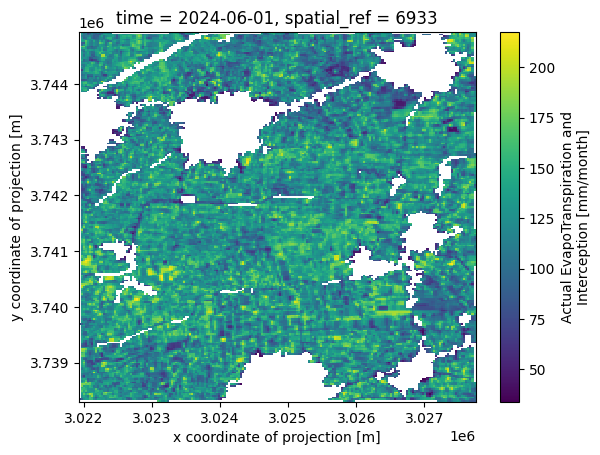

In [34]:
eta_xr_crop.isel(time=5)['L3-AETI-M'].plot()

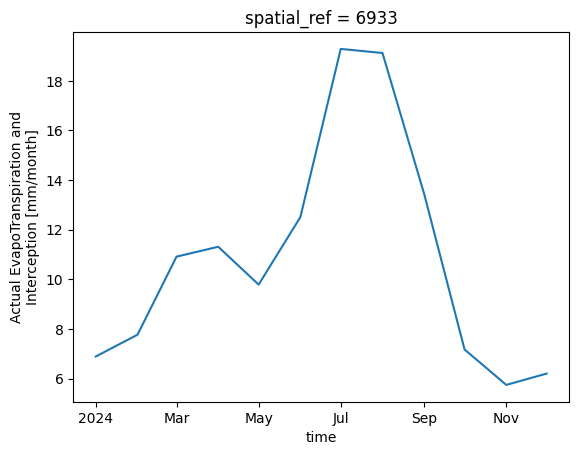

In [36]:
(eta_xr_crop.mean(['x', 'y'])['L3-AETI-M']*0.1).plot()

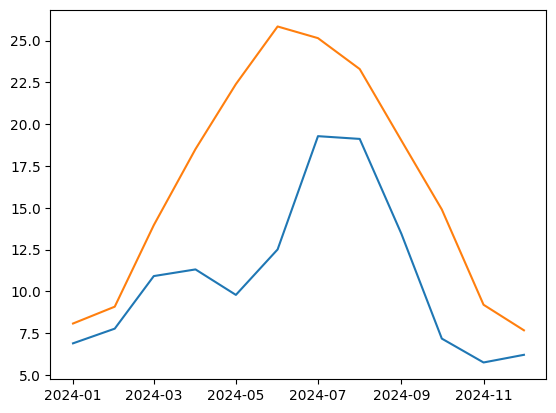

In [38]:
plt.plot(eta_xr_crop.mean(['x', 'y']).time, eta_xr_crop.mean(['x', 'y'])['L3-AETI-M']*0.1)
plt.plot(ret_ts.time, ret_ts['L1-RET-M']*0.1)

### Subheading 1
Use subheadings to break up steps within a single section.

In [ ]:
# Use code comments for low-level documentation of code
b = 2

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [ ]:
# Use code comments for low-level documentation of code
c = 3

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')